# Basic Neural Network

✨ Building an NN (Neural network) requires piecing together components together to perform a particular task.

- Note that for the task below, since were only counting, a basic regression model could also be used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.basic_nn import draw_image_cell_image

# Reloads external functions when their code changes into this notebook.
%load_ext autoreload
%autoreload 1
# %aimport will only reload those files
# %aimport utils.bboxes
%aimport utils.basic_nn

**Task: Create a NN (Neural Network) that can count the number of black cells in a image.**

## Dataset

- We have a $(3,3) = 9$ pixel image with black and white cells:
    - A $0 =$ black cell, a $1 =$ white cell.

In [2]:
image_array = np.array([
    [1, 1, 0],
    [1, 0, 1],
    [1, 0, 1]
])
image_array

array([[1, 1, 0],
       [1, 0, 1],
       [1, 0, 1]])

Plot what the image looks like. Ignore the purple lines there just to emphasize the cells, and the 0 and 1 are just for show.

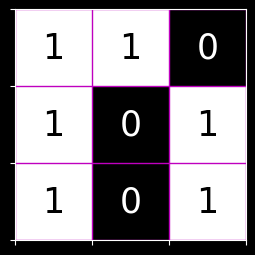

In [3]:
draw_image_cell_image(image_array)

### Preprocess The Dataset

**Inputs And Labels:**
- Inputs can also be noted as ****features**** or ****x****.
    - The input is the image_array
    - Each pixel is a single feature.
    - The input is what we will train the model on.
    - Reshape the (3x3) image array into a (9, 1) vector, so we can pass it through the model.

- Labels can also be noted as **target**, ****ground truth**** or ****y****.
    - When the model makes output predictions, we will compare it to the label, the more it matches the better our model is trained on that dataset.
  
    - Classes (num_classes=10):
        - Class 0: The image has 0 black cells.
        - Class 1: The image has 1 black cell.
        - ...
        - Class 9: The image has 9 black cells.
    - One-hot encode:
      - We need to create a one-hot encoded label to represent the label
        - Ex: $[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$
          - The label indicates $4$ is how many black cells are in the image, since $1$ is in the third index (zero-based indexing)


In [4]:
numBlackCells = np.count_nonzero(image_array == 0)

# Create the one-hot encoded label
num_classes = 10
y = np.zeros((1, num_classes))
y[0, numBlackCells] = 1

print("\nOne-hot label for a count of 3:\n", y)


One-hot label for a count of 3:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


Reshape the (3x3) image array into a (9, 1) vector, so we can pass it through the model.

In [10]:
# Flatten the image array into a 1D vector of 9 features
flatten_image_array = image_array.flatten().reshape(-1, 1)
print("Flattened image input vector:\n", flatten_image_array)

Flattened image input vector:
 [[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]]


### Normalize

- For image datasets, to make the model train faster and converge better we normalize the image data pixel values to be between $[0,1]$, 
    - Regular **greyscale** values are:
        - $0$ value represents black and $255$ value represents white pixel.
- However, since our image is already made of just **0s and 1s**, it's already in a small, stable range. We can skip normalization for this dataset.


## Create A Basic NN Model

**Prerequisite:**
- [Softmax](./activation_functions/softmax.ipynb)

**Network:**
<p align="center">
    <img src="./showcase_images/network_with_10_outputs.png" alt="logistic regression network" width="80%">
</p>

Network description:
- The input layer has $9$ neurons one for each pixel then $x_n$ and $w_n$ would be $x_{9}$ and $w_{9}$
    - $x_1$ = is the first pixel of the image.
    - $x_2$ = is the second pixel.
    - $x_{n} = x_{9}$ = is the $9'th$ pixel.

    - $w_n = $ 9, to match the input features.

- The output has $10$ neurons, one for each possible count (0 through 9).
  - Example: An image can have a max of $9$ black pixels and a minimal of $0$ black pixels, we want the model to predict a number between $[0,9]$
    - $[0.1, 0.0, 0.4, 0.0, 0.0, 0.1, 0.2, 0.2, 0.0, 0.0]$
      - $0.4$ is the highest value the model predicted that. 
        - $0.4$ is in the second index (zero-based indexing) so that means the model predicts that the number of black pixels in the image is $2$.

Train Steps:
1. Forward propagation. Where we train the model
2. Backward propagation. Where we update the model to make it make more acret

#### Learned Parameters

`w` (weights) & `b` (bias).
- `w:`
    -  Each weight neuron determine the importance or influence of each input feature on the neuron's output. Each feature/pixel has a corresponding weight w. A large weight means that a change in the input will have a significant impact on the output.

    - In this network each weight node is connected to every input neuron.

    - The w has the same number of **neurons** as an input sample.
        - A sample is one example of a dataset, for this example dataset, we only have one image, so we have one sample.

    - Randomly initializing the weights. This is crucial to break symmetry, which ensures that each weight neuron learns a unique function.
        - We are using the [Xavier Initialization](./param_initializers/Xavier_init.ipynb), but there are other initialization algorithms such as the [He algorithm](./param_initializers/He_init.ipynb). 
        - If all weights were initialized to the same value like $0$, all neurons in a layer would learn the exact same thing, making the network ineffective.

- `b:`
    - This is a constant value added to the linear combination of inputs and weights. It allows the model to shift the activation function curve to the left or right, independent of the input values. The bias essentially gives the neuron a degree of flexibility, allowing it to fire even if all inputs are zero or to not fire even if there are high inputs.
    - Bias can be initialized to be 0.

In [11]:
def init_weights_and_bias(n_in=9, n_out=1):
    """
    Initialize the weights and bias. Initializing the weights using the Xavier algorithm, set bias scalar to be zero.

    Args:
        n_in: The total number of input features/neurons, this dataset its 9 pixels.
        n_out: The total number of output neurons, since this network is just a input to output network, meaning we have no layers, we use 1 n_out which then gets sigmoid applied to it, to get the models output.

    returns:
        w : weights array
        b : scalar
    """
    # Xavier Uniform Initialization, note theres also a Xavier Normal Initialization.
    limit = np.sqrt(6 / (n_in + n_out))
    # Create the weight matrix with random values from a uniform distribution
    w = np.random.uniform(-limit, limit, size=(n_out, n_in))

    # Initialize bias (b) to zeros
    b = np.zeros((1, n_out))
    return w, b

In [12]:
w, b = init_weights_and_bias(n_in=9, n_out=10) # softmax function expects 10
w, b

(array([[ 0.06495111, -0.55464097,  0.36804813,  0.47925215,  0.52715839,
         -0.28084445,  0.52096595,  0.20128627, -0.0256567 ],
        [-0.3516144 , -0.30104466,  0.20563233, -0.03103297,  0.40187344,
          0.48877552,  0.47548505, -0.39950541,  0.26568792],
        [-0.33191267,  0.26956716,  0.28342505, -0.27356339,  0.09376107,
         -0.46267874,  0.04364748, -0.11047292,  0.44786794],
        [-0.3973079 , -0.08742557,  0.05364788, -0.54560155, -0.15290978,
          0.39185526, -0.42761787,  0.31210657, -0.09388759],
        [ 0.1541925 ,  0.25519112,  0.17883092, -0.53416436, -0.52456117,
         -0.25541772,  0.08643212, -0.09665057, -0.45765328],
        [-0.44420232,  0.15138703, -0.09560852,  0.31813356,  0.45644259,
          0.2794617 , -0.15958103, -0.49730656,  0.41348808],
        [ 0.10322178,  0.32293196, -0.07608702,  0.13948773,  0.17968399,
         -0.27300098, -0.23220257,  0.1204129 ,  0.16643176],
        [-0.07384989,  0.26890124,  0.52105352, 

In [13]:
w.shape, b.shape

((10, 9), (1, 10))

- The weights `w` have a shape of **(10, 9)**. This represents the 10 output neurons, each connected to all 9 input pixels. The bias `b` has a shape of **(1, 10)**, with one bias value for each output neuron.

### Forward Propagation

$$z^{(i)} = w * x^{(i)}+ b$$

$$\hat{y}^{(i)} = a^{(i)} = \sigma(z^{(i)}) = sigmoid(z^{(i)})$$

- **Notes:** 
    - $a^{(i)} $ & $ \sigma(z^{(i)})$ & $sigmoid(z^{(i)})$ mean the same thing, its just different ways that you might see it annotated.
    - $^{(i)}$ means its for one example/sample, the dataset we have only has 1 image, so that is our one sample:

    - **Compute Linear**:
      - $W$ is the weights.
      - $b$ is the bias.
      - Calculate the scores (logits) for each of the 10 classes

    - **Compute non-linear activation:**
      - Apply [$softmax()$](./activation_functions/softmax.ipynb) to the $Z$ to convert those (logits) scores into probabilities.

In [14]:
def linear(x, w, b):
    """
    Performs a forward pass of the network.
    
    Args:
        x: Input data, shape (9, 1)
        w: Weights, shape (10, 9)
        b: Bias, shape (1, 10)
    """
    # Note: We transpose x to (1, 9) to match bias shape (1, 10)
    # The dot product w @ x.T results in shape (10, 1)
    # So we transpose the result to (1, 10) before adding the bias
    z = (w @ x).T + b
    return z

In [15]:
z = linear(x=flatten_image_array, w=w, b=b)
z

array([[ 0.20402709,  0.54625646, -0.30707221, -1.15998522, -0.75141963,
         0.55868702,  0.22686968, -0.3938715 , -0.95601646, -1.20410878]])

**Activation Function**

In [16]:
def softmax(z):
    """Applies the softmax activation function."""
    # Subtract max for numerical stability
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)

In [17]:
probabilities = softmax(z)
probabilities

array([[0.13879191, 0.19543056, 0.08325236, 0.0354798 , 0.05338496,
        0.19787503, 0.14199876, 0.07633085, 0.04350745, 0.03394834]])

In [ ]:
# The highest probability is our predicted class (the count of black cells)
predicted_count = np.argmax(probabilities)

In [21]:
print("Output Probabilities (y_hat):\n", probabilities)
print("\nModel predicted:", predicted_count, "vs real number of black cells:", numBlackCells)

Output Probabilities (y_hat):
 [[0.13879191 0.19543056 0.08325236 0.0354798  0.05338496 0.19787503
  0.14199876 0.07633085 0.04350745 0.03394834]]

Model predicted: 5 vs real number of black cells: 3


Now lets perform backpropagation to improve the prediction.

### Backward Propagation
backward propagation: use Stochastic Gradient Descent (SGD) 

TODO

TODO Model performs terrible, but it has so far only seen the image once, lets make it see the image more than.